In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

In [2]:
def gaussian_kernel(sigma_x,kernel_size):
    """returns a gaussian blur kernel"""
    
    kernel = np.zeros((kernel_size,kernel_size))
    
    h = 1/(2.0*np.pi*sigma_x*sigma_x)
    
    n= kernel_size//2
            
    for i in range(-n,n+1):
        for j in range(-n,n+1):
            p =  ((i**2)+(j**2))/(2*(sigma_x**2))
            kernel[i+n,j+n] = h*np.exp(-p)
    
    print(kernel/np.min(kernel))
    return kernel

def convolution(img, kernel):
    n = kernel.shape[0]//2
    #img_bordered = cv2.copyMakeBorder(img, top=n , bottom=n , left=n , right=n, borderType=cv2.BORDER_CONSTANT)
    
    out = np.zeros((img.shape[0],img.shape[1],1))
    
    for x in range(n,img.shape[0]-n):
        for y in range(n, img.shape[1]-n):
            sum=0
            for i in range(-n,n+1):
                for j in range(-n,n+1):
                    sum+= img[x-i,y-j] * kernel[i+n,j+n]
            out[x,y] = sum
    
    return out

def x_derivatives(sigma,kernel_size):
    kernel = np.zeros((kernel_size,kernel_size))
    
    n = kernel_size//2
    
    h = 1/(2.0*math.pi*(sigma**2))
            
    for i in range(-n,n+1):
        for j in range(-n,n+1):
            p = ((i**2)+(j**2))/(2*(sigma**2))
            kernel[i+n,j+n] = (-i/(sigma**2))*h*np.exp(-p)
    
    #print(kernel)
    return kernel

def y_derivatives(sigma,kernel_size):
    kernel = np.zeros((kernel_size,kernel_size))
    n = kernel_size//2
    
    h = 1/(2.0*math.pi*(sigma**2))
            
    for i in range(-n,n+1):
        for j in range(-n,n+1):
            p = ((i**2)+(j**2))/(2*(sigma**2))
            kernel[i+n,j+n] = (-j/(sigma**2))*h*np.exp(-p)
    
    #print(kernel)
    return kernel

def gradient_magnitude(img1,img2):
    m,n = img1.shape[0],img2.shape[1]
    output = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            output[i,j] = math.sqrt((img1[i,j]**2)+(img2[i,j]**2))
      
    return output

def non_max_suppression(img,angle):
    
    m,n=img.shape[0],img.shape[1]
    out = np.zeros(img.shape)
    img = img/img.max()*255
    
    for i in range (m-1):
        for j in range(n-1):
            try:
                if(0<=angle[i,j]<22.5 or 157.5<=angle[i,j]<=180):
                    q=img[i,j+1]
                    r=img[i,j-1]
                elif(22.5<=angle[i,j]<=67.5):
                    q=img[i-1,j-1]
                    r=img[i+1,j+1]
                elif(67.5<=angle[i,j]<=112.5):
                    q=img[i-1,j]
                    r=img[i+1,j]
                else:
                    q=img[i-1,j+1]
                    r=img[i+1,j-1]
                    
                if(img[i,j]<q or img[i,j]<r):
                    out[i,j]=0
                else:
                    out[i,j]=img[i,j]
                    
            except IndexError as e:
                pass
    
    return out

def find_threshold(img):
    
    oldThreshold = np.mean(img)
    
    newThreshold = threshold_generator(img,oldThreshold)
    
    while(abs(newThreshold-oldThreshold) > 0.1 ** 6):
        oldThreshold = newThreshold
        newThreshold = threshold_generator(img,oldThreshold)
        
    return newThreshold
    
    
def threshold_generator(img,threshold):
    m,n = img.shape
    
    sum1 = 0
    sum2 = 0
    n1 = 0
    n2 = 0
    
    for x in range(m):
        for y in range(n):
            if img[x,y]>threshold:
                sum1+=img[x,y]
                n1+=1
            else:
                sum2+=img[x,y]
                n2+=1
    
    highthreshold = sum1/n1
    lowthreshold = sum2/n2
    
    return (highthreshold+lowthreshold)/2
    

def doubleThresholding(img):
    
    threshold = find_threshold(img)
    
    weak = np.uint8(75)
    strong = np.uint8(255)
    
    out = np.zeros(img.shape)
    
    highThreshold = threshold * .5
    lowThreshold = highThreshold * .5
    
    strong_i,strong_j = np.where(img>=highThreshold)
    zeros_i, zeros_j = np.where(img<=lowThreshold)
    
    weak_i,weak_j = np.where((img>=lowThreshold) & (img<=highThreshold))
    
    out[strong_i,strong_j] = strong
    out[weak_i,weak_j] = weak
    out[zeros_i,zeros_j] = 0
    
    return out

def hysteresis(img):
    
    out = img.copy()
    
    weak = 75
    strong =255

    m,n = img.shape[0],img.shape[1]
    
    for i in range(1,m-1):
        for j in range(1,n-1):
            if(out[i,j]==weak):
                 out[i,j] = strong if (out[i-1,j-1]==strong or out[i-1,j]==strong or out[i-1,j+1]==strong or out[i,j-1]==strong or out[i,j+1]==strong or out[i+1,j-1]==strong or out[i+1,j]==strong or out[i+1,j+1]==strong) else 0       
    
    return out
    
def CannyEdgeDetector(img,sigma,kernel_size):
    blurred_img = convolution(img,gaussian_kernel(sigma,kernel_size))
    
    I_x = convolution(blurred_img,x_derivatives(sigma,kernel_size)) 
    I_y = convolution(blurred_img,y_derivatives(sigma,kernel_size))
    
    I_mag = gradient_magnitude(I_x,I_y)
    
    angles = np.arctan2(I_y.copy(),I_x.copy())
    
    nms = non_max_suppression(I_mag,angles)
    
    dbl_thresholded = doubleThresholding(nms)
    
    final_output = hysteresis(dbl_thresholded)
    
    
    cv2.normalize(final_output,final_output,0,255,cv2.NORM_MINMAX)
    final_output = np.round(final_output).astype(np.uint8)
    
    
    return final_output

In [3]:
image_path = "stairs.png"
img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
if (img.shape[0]>1000 or img.shape[1]>1000):
    img = cv2.resize(img, (0, 0), fx=0.3, fy=0.3)

edged = CannyEdgeDetector(img,.7,5)

[[1.00000000e+00 2.13536885e+01 5.92421128e+01 2.13536885e+01
  1.00000000e+00]
 [2.13536885e+01 4.55980014e+02 1.26503762e+03 4.55980014e+02
  2.13536885e+01]
 [5.92421128e+01 1.26503762e+03 3.50962792e+03 1.26503762e+03
  5.92421128e+01]
 [2.13536885e+01 4.55980014e+02 1.26503762e+03 4.55980014e+02
  2.13536885e+01]
 [1.00000000e+00 2.13536885e+01 5.92421128e+01 2.13536885e+01
  1.00000000e+00]]


C:\Users\mdrak\AppData\Local\Temp\ipykernel_21960\107876933.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[i,j] = math.sqrt((img1[i,j]**2)+(img2[i,j]**2))


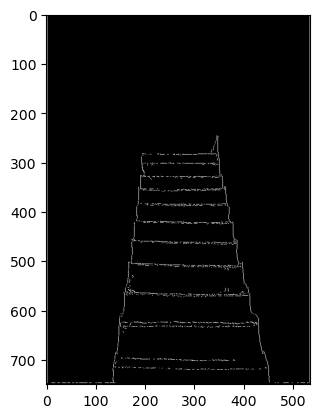

In [4]:
plt.imshow(edged,cmap='gray')

In [5]:
def hough_line_transform(threshold,edge_coordinates):
    diagonal_length = np.ceil(np.sqrt(img.shape[0]**2+img.shape[1]**2))
    
    theta_values = np.deg2rad(np.arange(-90,90,1))
    r_values = np.arange(-diagonal_length,diagonal_length+1,1)
    
    m,n = len(r_values),len(theta_values)
    
    accumulator = np.zeros((m,n))
    
    costhetas = np.cos(theta_values)
    sinthetas = np.sin(theta_values)
    
    for x,y in zip(edge_coordinates[0],edge_coordinates[1]):
        for theta in range(n):
            r = x*costhetas[theta] + y*sinthetas[theta]
            r_idx = np.where(r > r_values)[0][-1]
            accumulator[r_idx,theta] += 1
    
    final_r_idx,final_theta_idx = np.where((accumulator>threshold))
    final_r_values = r_values[final_r_idx]
    final_theta_values = theta_values[final_theta_idx]
    
    return final_r_values,final_theta_values   

In [6]:
edge_coordinates = np.where(edged==255)

final_r , final_theta = hough_line_transform(50, edge_coordinates)



0.9998468591309431
2.9995405008176514
3.9907322371530776
8.0
10.007164424621832
12.998009168702259
13.997873591202117
16.00628762370736
17.006146664556173
5.086495551093175
13.085283459749046
18.0
24.092334685038416
0.9998569292301085
4.903999219694924
27.004610558020833
3.1129762401334546
24.118513047559993
26.109483663999306
28.0
20.88016680564974
26.013496395579015
28.013193325963204
30.886549358171578
20.581171986512977
21.55361704016476
23.904512635271082
24.90390718430362
25.92075091767214
29.01303347076611
1.8603534308058443
0.5254916132570879
4.771815312310812
7.2702857333046165
8.310708866999638
8.810633465592234
12.318829045895974
14.163608554928942
17.163608554928942
19.81768464494647
3.3230799953305494
7.484195770180649
8.483589325584447
10.971958278686476
11.971798438470282
13.980221542969549
14.980078640399737
15.807803163443168
16.807803163443168
19.807803163443168
5.9402996111108415
6.431498192249785
9.749199553072685
10.749199553072685
13.93036133334854
18.749199553072

C:\Users\mdrak\AppData\Local\Temp\ipykernel_21960\364159987.py:6: RuntimeWarning: invalid value encountered in scalar divide
  m1 = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0])


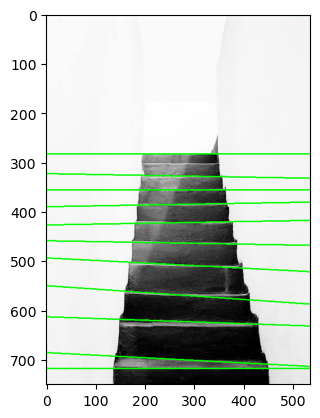

In [7]:
def polar2cartesian(radius: np.ndarray, angle: np.ndarray, cv2_setup: bool = True) -> np.ndarray:
    return radius * np.array([np.sin(angle), np.cos(angle)])

def distance_between_lines(pt1, pt2, pt3, pt4):

    m1 = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0])
    
    m2 = (pt4[1] - pt3[1]) / (pt4[0] - pt3[0])
    

    b1 = pt1[1] - m1 * pt1[0]
    b2 = pt3[1] - m2 * pt3[0]
    
    distance = np.abs(b1 - b2) / np.sqrt(m1**2 + 1)
    
    return distance

new_img = cv2.imread(image_path)
if (new_img.shape[0]>1000 or new_img.shape[1]>1000):
    new_img = cv2.resize(new_img, (0, 0), fx=0.3, fy=0.3)

i=0

lines = []

distance = 100

for rho,theta in zip(final_r,final_theta):
    if -1<theta<1:
        x0 = polar2cartesian(rho, theta)
        # print(x0)
        direction = np.array([x0[1], -x0[0]])
        # print(direction)
        pt1 = np.round(x0 + 1000*direction).astype(int)
        pt2 = np.round(x0 - 1000*direction).astype(int)
        line = [pt1,pt2]
        if(lines!=[]):
            for ln in lines:
                pt3,pt4 = ln
                distance = distance_between_lines(pt1,pt2,pt3,pt4)
                if(distance<31):
                    print(distance)
                    break
                    
        if(distance>31):     
            lines.append([pt1,pt2])
            cv2.line(new_img,pt1=pt1, pt2=pt2, color=[0,255,0], thickness=2)
            i += 1 
        
# print(lines)
print(f"no of lines drawn : {i}")
plt.imshow(new_img)
# plt.imshow(img)


In [8]:
# lines = cv2.HoughLines(edged,1,np.pi/180,80)
# k = 3000
# i=0

# rho,theta = lines[0][0]
# print(rho,theta)

# new_img2 = cv2.imread(image_path)
# if (new_img2.shape[0]>1000 or new_img2.shape[1]>1000):
#     new_img2 = cv2.resize(new_img2, (0, 0), fx=0.3, fy=0.3)

# for line in lines:
#     if -1<theta<1:
#         rho, theta = line[0]
#         x0 = polar2cartesian(rho, theta)
#         direction = np.array([x0[1], -x0[0]])
#         pt1 = np.round(x0 + 2000*direction).astype(int)
#         pt2 = np.round(x0 - 2000*direction).astype(int)
#         cv2.line(new_img2,pt1=pt1, pt2=pt2, color=[0,255,0], thickness=2)
#         i += 1 

    
# print(i)
# plt.imshow(new_img2) 
    